对wine reviews和Oakland Crime Statistics 2011 to 2016数据集进行分析。
程序所在代码仓库地址：https://github.com/Graceqi/Data-preprocessing

Import libraries

In [1]:
import pandas as pd
import numpy as np
import copy
from scipy import stats
from collections import Counter
import matplotlib.pyplot as plt
from fancyimpute import KNN
import re

Using TensorFlow backend.


首先是对wine reviews数据进行处理分析。

In [2]:
wine_path = "D:\\数据挖掘课件视频\\数据集\\2\\wine-reviews\\winemag-data-130k-v2.csv"
wine_data = pd.read_csv(wine_path)
wine_data2 = copy.deepcopy(wine_data)#深拷贝
wine_data3 = copy.deepcopy(wine_data)#深拷贝
wine_data4 = copy.deepcopy(wine_data)#深拷贝
wine_list = wine_data.columns.values.tolist()
print(wine_list)

['Unnamed: 0', 'country', 'description', 'designation', 'points', 'price', 'province', 'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title', 'variety', 'winery']


一、标称属性，给出每个可能聚会的频数。标称属性有'country', 'designation','province', 'region_1', 'region_2', 'taster_name', 'taster_twitter_handle',  'variety', 'winery'。首先统计输出了每个标称属性中聚会的频数。然后由于属性值类别太多，而且出现频数差距较大，因此，在用条形图可视化显示聚会频数时，每个属性都只显示出现频数在前25的属性值，这样也已涵盖绝大多数数据还方便观察。

The distribution of country
 US                        54504
France                    22093
Italy                     19540
Spain                      6645
Portugal                   5691
Chile                      4472
Argentina                  3800
Austria                    3345
Australia                  2329
Germany                    2165
New Zealand                1419
South Africa               1401
Israel                      505
Greece                      466
Canada                      257
Hungary                     146
Bulgaria                    141
Romania                     120
Uruguay                     109
Turkey                       90
Slovenia                     87
Georgia                      86
England                      74
Croatia                      73
Mexico                       70
Moldova                      59
Brazil                       52
Lebanon                      35
Morocco                      28
Peru                         16
Ukraine    

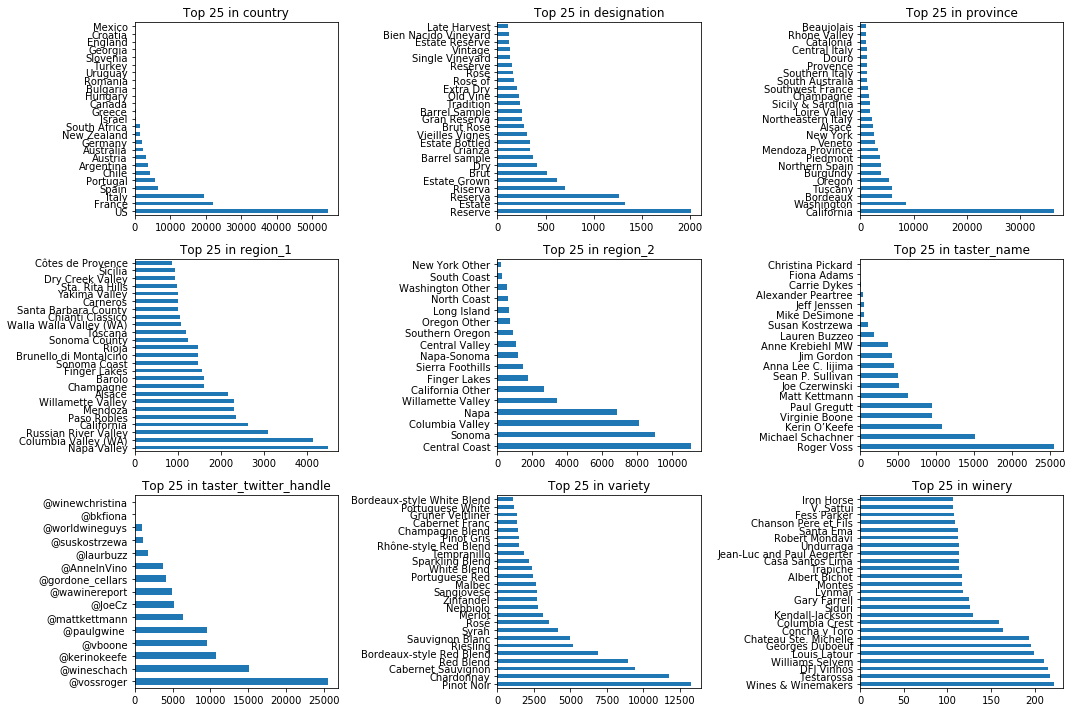

In [3]:
country=wine_data['country'].value_counts()
designation=wine_data['designation'].value_counts()
province=wine_data['province'].value_counts()
region_1=wine_data['region_1'].value_counts()
region_2=wine_data['region_2'].value_counts()
taster_name=wine_data['taster_name'].value_counts()
taster_twitter_handle=wine_data['taster_twitter_handle'].value_counts()
variety=wine_data['variety'].value_counts()
winery=wine_data['winery'].value_counts()
print("The distribution of country\n",country)
print("The distribution of designation\n",designation)
print("The distribution of province\n",province)
print("The distribution of region_1\n",region_1)
print("The distribution of region_2\n",region_2)
print("The distribution of taster_name\n",taster_name)
print("The distribution of taster_twitter_handle\n",taster_twitter_handle)
print("The distribution of variety\n",variety)
print("The distribution of winery\n",winery)
top=25
list_nominal=[country[:top],designation[:top],province[:top],region_1[:top],region_2[:top],taster_name[:top],taster_twitter_handle[:top],variety[:top],winery[:top]]
list_name=['country','designation','province','region_1','region_2','taster_name','taster_twitter_handle','variety','winery']
fig,axes=plt.subplots(3,3)
for d,i in zip(list_nominal,range(9)):
    ax=axes.ravel()[i]
    ax.set_title(f"Top 25 in {list_name[i]}")
    d.plot.barh(ax=ax,figsize=(15,10))
    plt.tight_layout()

二、数值属性，给出5数概括及缺失值的个数。下面分别计算缺失值个数。

                    index  missNum  missRate
8                region_2    79460  0.611367
3             designation    37465  0.288257
10  taster_twitter_handle    31213  0.240154
9             taster_name    26244  0.201922
7                region_1    21247  0.163475
5                   price     8996  0.069215
1                 country       63  0.000485
6                province       63  0.000485
12                variety        1  0.000008
0              Unnamed: 0        0  0.000000
2             description        0  0.000000
4                  points        0  0.000000
11                  title        0  0.000000
13                 winery        0  0.000000


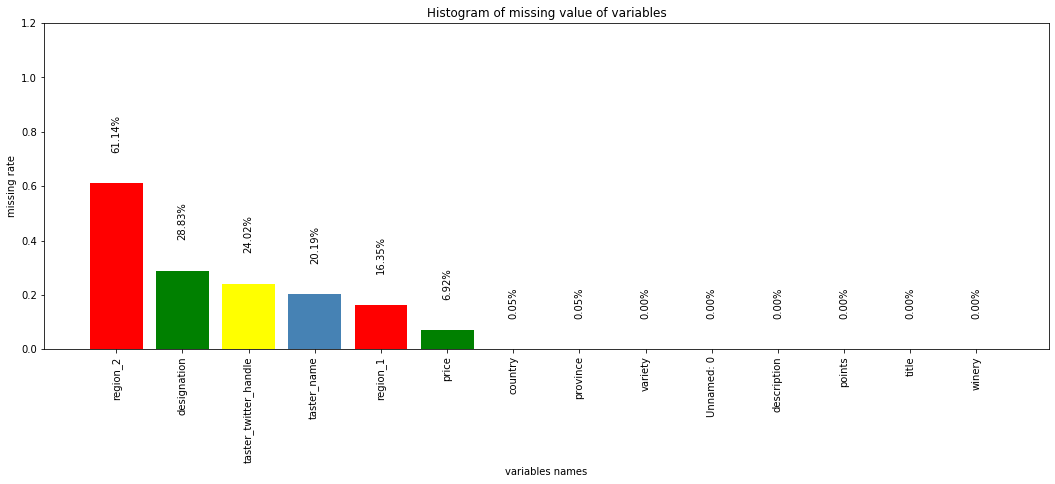

In [4]:
# 统计缺失值数量
missing=wine_data.isnull().sum().reset_index().rename(columns={0:'missNum'})
# 计算缺失比例
missing['missRate']=missing['missNum']/wine_data.shape[0]
# 按照缺失率排序显示
miss_analy=missing[missing.missRate>=0].sort_values(by='missRate',ascending=False)
print(miss_analy)
# miss_analy 存储的是每个变量缺失情况的数据框
fig = plt.figure(figsize=(18,6))
plt.bar(np.arange(miss_analy.shape[0]), list(miss_analy.missRate.values), align = 'center',color=['red','green','yellow','steelblue'])

plt.title('Histogram of missing value of variables')
plt.xlabel('variables names')
plt.ylabel('missing rate')
# 添加x轴标签，并旋转90度
plt.xticks(np.arange(miss_analy.shape[0]),list(miss_analy['index']))
plt.xticks(rotation=90)
# 添加数值显示
for x,y in enumerate(list(miss_analy.missRate.values)):
    plt.text(x,y+0.12,'{:.2%}'.format(y),ha='center',rotation=90)    
plt.ylim([0,1.2])
    
plt.show()

计算五数。五数中的最大值是选取数据中的最大值与Q3 + 1.5 * IQR的较小值，五数中的最小值是选取数据中的最小值与Q1 - 1.5 * IQR的较大值。用于发现离散点。

In [5]:
#去掉缺失值计算五数
wine_data.dropna(subset=['points'], inplace=True)
wine_data.dropna(subset=['price'], inplace=True)
#中位数
Median_po = np.median(wine_data.points)
Median_pr = np.median(wine_data.price)
#四分之一分位数
Q1_po = np.percentile(wine_data.points, 25) 
Q1_pr = np.percentile(wine_data.price, 25)
#四分之三中位数
Q3_po = np.percentile(wine_data.points, 75)
Q3_pr = np.percentile(wine_data.price, 75)
#最大值
max_po = np.amax(wine_data.points)
max_pr = np.amax(wine_data.price)
#最小值
min_po = np.amin(wine_data.points)
min_pr = np.amin(wine_data.price)
#IQR
IQR_po = Q3_po - Q1_po
IQR_pr = Q3_pr - Q1_pr
#Minimum
Minimum_po = max(Q1_po - 1.5 * IQR_po,min_po)
Minimum_pr = max(Q1_pr - 1.5 * IQR_pr,min_pr)
#Maximum
Maximum_po=min(Q3_po + 1.5 * IQR_po,max_po)
Maximum_pr=min(Q3_pr + 1.5 * IQR_pr,max_pr)
#五数输出
print("The Five-number of points： Minimum, Q1, Median, Q3, Maximum", Minimum_po, Q1_po, Median_po, Q3_po, Maximum_po)
print("The Five-number of price： Minimum, Q1, Median, Q3, Maximum", Minimum_pr, Q1_pr, Median_pr, Q3_pr, Maximum_pr)

The Five-number of points： Minimum, Q1, Median, Q3, Maximum 80 86.0 88.0 91.0 98.5
The Five-number of price： Minimum, Q1, Median, Q3, Maximum 4.0 17.0 25.0 42.0 79.5


三、数据可视化，使用直方图、盒图等检查数据分布及离群点

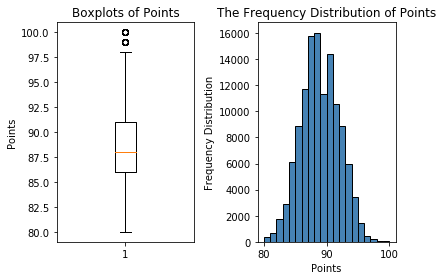

In [6]:
#画盒图
plt.subplot(1,2,1)
plt.boxplot(x=wine_data.points)
# 添加y轴标签
plt.ylabel('Points')
# 添加标题
plt.title('Boxplots of Points')
plt.tight_layout()

plt.subplot(1,2,2)
plt.hist(x = wine_data.points, # 指定绘图数据
         bins = 20, # 指定直方图中条块的个数
         color = 'steelblue', # 指定直方图的填充色
         edgecolor = 'black' # 指定直方图的边框色
         )
# 添加x轴和y轴标签
plt.xlabel('Points')
plt.ylabel('Frequency Distribution')
# 添加标题
plt.title('The Frequency Distribution of Points')
plt.tight_layout()
plt.show()


由上图可以看出酒的分数比较接近正态分布，离散点只有两个。

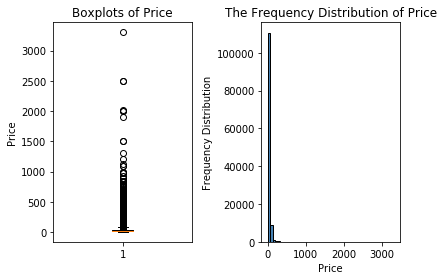

In [7]:
#画盒图
plt.subplot(1,2,1)
plt.boxplot(x=wine_data.price)
# 添加y轴标签
plt.ylabel('Price')
# 添加标题
plt.title('Boxplots of Price')
plt.tight_layout()

plt.subplot(1,2,2)
plt.hist(x = wine_data.price, # 指定绘图数据
         bins = 50, # 指定直方图中条块的个数
         color = 'steelblue', # 指定直方图的填充色
         edgecolor = 'black' # 指定直方图的边框色
         )
# 添加x轴和y轴标签
plt.xlabel('Price')
plt.ylabel('Frequency Distribution')
# 添加标题
plt.title('The Frequency Distribution of Price')
plt.tight_layout()
plt.show()


由上图可看出酒的价格比较分散，悬殊较大，主要集中在4-79之间，最贵的高达3300。

四、观察数据集中缺失数据，分析其缺失的原因。分别使用下列四种策略对缺失值进行处理:
1、将缺失部分剔除
2、用最高频率值来填补缺失值
3、通过属性的相关关系来填补缺失值
4、通过数据对象之间的相似性来填补缺失值
因为point没有缺失值，所以只需处理price数据

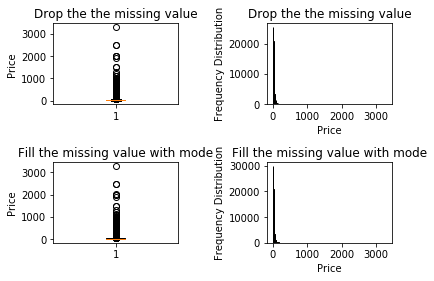

In [8]:
#1、将缺失部分剔除的盒图和直方图
plt.subplot(2,2,1)
wine_data.dropna(subset=['price'], inplace=True)
plt.boxplot(x=wine_data.price)
# 添加y轴标签
plt.ylabel('Price')
# 添加标题
plt.title('Drop the the missing value')
plt.tight_layout()
plt.subplot(2,2,2)
plt.hist(x = wine_data.price, # 指定绘图数据
         bins = 500, # 指定直方图中条块的个数
         color = 'orange', # 指定直方图的填充色
         edgecolor = 'black' # 指定直方图的边框色
         )
# 添加x轴和y轴标签
plt.xlabel('Price')
plt.ylabel('Frequency Distribution')
# 添加标题
plt.title('Drop the the missing value')
plt.tight_layout()

#2、将用最高频率值来填补缺失值的盒图和直方图
plt.subplot(2,2,3)
mode=stats.mode(wine_data2['price'])[0][0]
wine_data2['price']=wine_data2['price'].fillna(mode)
plt.boxplot(x = wine_data2.price)
# 添加y轴标签
plt.ylabel('Price')
# 添加标题
plt.title('Fill the missing value with mode')
plt.tight_layout()
plt.subplot(2,2,4)
plt.hist(x = wine_data2.price, # 指定绘图数据
         bins = 500, # 指定直方图中条块的个数
         color = 'orange', # 指定直方图的填充色
         edgecolor = 'black' # 指定直方图的边框色
         )
# 添加x轴和y轴标签
plt.xlabel('Price')
plt.ylabel('Frequency Distribution')
# 添加标题
plt.title('Fill the missing value with mode')
plt.tight_layout()
plt.show()

上图可明显看出使用用最高频率值来填补缺失值后的直方图分布与之前有很大不同。

D:\annaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


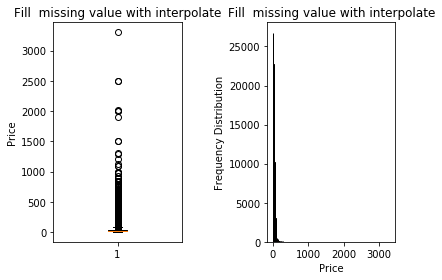

In [9]:
#3、通过属性的相关关系来填补缺失值 
#interpolate()插值法,计算的是缺失值前一个值和后一个值的平均数，无法解决第一个值为空值的情况，所以直接把第二个值赋给第一个值
wine_data3['price'] = wine_data3['price'].interpolate()
wine_data3['price'][0]=wine_data3['price'][1]
plt.subplot(1,2,1)
plt.boxplot(x=wine_data3.price)
# 添加y轴标签
plt.ylabel('Price')
# 添加标题
plt.title('Fill  missing value with interpolate')
plt.tight_layout()
plt.subplot(1,2,2)
plt.hist(x =wine_data3.price, # 指定绘图数据
         bins = 500, # 指定直方图中条块的个数
         color = 'orange', # 指定直方图的填充色
         edgecolor = 'black' # 指定直方图的边框色
         )
# 添加x轴和y轴标签
plt.xlabel('Price')
plt.ylabel('Frequency Distribution')
# 添加标题
plt.title('Fill  missing value with interpolate')
plt.tight_layout()
plt.show()

使用knn算法，找出与缺失数据对象最相近的k个数据对象的方法来填充。

In [10]:
#4、通过数据对象之间的相似性来填补缺失值
#选用knn，找出与缺失数据最相似的k的数据对象的值来填充
testdata=wine_data4[['price','points']]
x=[]
#KNN缺失数据填补
def knn_filled(testdata) :
    df = testdata
    #缺失填补
    if df.price.isnull().any():#判断数据是否有null
        data = pd.DataFrame()
        for i in range(0,df.shape[0],6):# 以60分钟为周期分段（10分钟粒度, 6个为周期）
            data1 = df["price"][i:i+6].reset_index(drop = True).rename(index = str(i))
            data = pd.concat((data, data1), axis = 1) #整合为一个dataframe，多个列
        data_incomplete = np.array(data)#转为array
        #预测缺失值
        filled_knn = KNN(k=3).fit_transform(data_incomplete)#利用knn填补缺失值
        data_complete = pd.DataFrame(filled_knn)#保存结果
        for i in range(0,data_complete.shape[1]):
            x.extend(data_complete[i].values.tolist())
    return x

paintdata=knn_filled(testdata)


Imputing row 1/6 with 1543 missing, elapsed time: 0.013
[KNN] Warning: 534/129972 still missing after imputation, replacing with 0


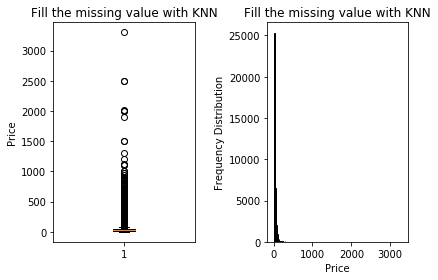

In [11]:
# plt.figure(figsize=(10,10))
#将缺失部分剔除的盒图和直方图
plt.subplot(1,2,1)
plt.boxplot(x=paintdata)
# 添加y轴标签
plt.ylabel('Price')
# 添加标题
plt.title('Fill the missing value with KNN')
plt.tight_layout()
plt.subplot(1,2,2)
plt.hist(x = paintdata, # 指定绘图数据
         bins = 500, # 指定直方图中条块的个数
         color = 'orange', # 指定直方图的填充色
         edgecolor = 'black' # 指定直方图的边框色
         )
# 添加x轴和y轴标签
plt.xlabel('Price')
plt.ylabel('Frequency Distribution')
# 添加标题
plt.title('Fill the missing value with KNN')
plt.tight_layout()
plt.show()

In [12]:
#jupyter误删恢复
# for line in locals()['In']:
#     print(line)

# #或者， 直接的
# history


现在开始对Oakland Crime Statistics 2011 to 2016数据集进行分析,发现几个数据集出现列名不统一的情况，需要修改统一。

In [13]:
import pandas as pd
import numpy as np
import copy
from scipy import stats
from collections import Counter
import matplotlib.pyplot as plt
from fancyimpute import KNN
import re

In [14]:
crime_data1 = pd.read_csv("D:\\数据挖掘课件视频\\数据集\\3\\oakland-crime-statistics-2011-to-2016\\records-for-2011.csv")
crime_data2 = pd.read_csv("D:\\数据挖掘课件视频\\数据集\\3\\oakland-crime-statistics-2011-to-2016\\records-for-2012.csv")
crime_data2.rename(columns={'Location 1':'Location'},inplace=True) 
crime_data3 = pd.read_csv("D:\\数据挖掘课件视频\\数据集\\3\\oakland-crime-statistics-2011-to-2016\\records-for-2013.csv")
crime_data3.rename(columns={'Location ':'Location'},inplace=True) 
crime_data4 = pd.read_csv("D:\\数据挖掘课件视频\\数据集\\3\\oakland-crime-statistics-2011-to-2016\\records-for-2014.csv")
crime_data4.rename(columns={'Location 1':'Location'},inplace=True)
crime_data5 = pd.read_csv("D:\\数据挖掘课件视频\\数据集\\3\\oakland-crime-statistics-2011-to-2016\\records-for-2015.csv")
crime_data6 = pd.read_csv("D:\\数据挖掘课件视频\\数据集\\3\\oakland-crime-statistics-2011-to-2016\\records-for-2016.csv")
crime_data=crime_data1.append(crime_data2)
crime_data=crime_data.append(crime_data3)
crime_data=crime_data.append(crime_data4)
crime_data=crime_data.append(crime_data5)
crime_data=crime_data.append(crime_data6)
crime_data.rename(columns={'Create Time':'Create_Time','Area Id':'Area_Id','Incident Type Id':'Incident_Type_Id','Incident Type Description':'Incident_Type_Description','Event Number':'Event_Number','Closed Time':'Closed_Time','Zip Codes':'Zip_Codes'},inplace=True) 
print(crime_data.columns.values.tolist())

['Agency', 'Create_Time', 'Location', 'Area_Id', 'Beat', 'Priority', 'Incident_Type_Id', 'Incident_Type_Description', 'Event_Number', 'Closed_Time', 'Zip_Codes']


一、标称属性，给出每个可能聚会的频数。标称属性有'Agency',  'Location', 'Area Id', 'Beat', 'Priority', 'Incident Type Id', 'Incident Type Description', 'Event Number', 'Zip Codes'。首先统计输出了每个标称属性中聚会的频数。然后由于属性值类别太多，而且出现频数差距较大，因此，在用条形图可视化显示聚会频数时，每个属性都只显示出现频数在前25的属性值，这样也已涵盖绝大多数数据还方便观察。Event Number的值是不重复唯一的，因此不画它的分布图。

The distribution of Agency
 OP    1046384
Name: Agency, dtype: int64
The distribution of Area Id
 1.0    290452
2.0    236700
P3     129054
P1     114560
P2      53033
3.0     32907
POU      5960
PCW       789
5.0       320
4.0       236
TEC        10
JLS         1
WAG         1
Name: Area_Id, dtype: int64
The distribution of Beat
 04X     43626
08X     38097
30Y     30880
26Y     30377
30X     29881
23X     29684
19X     29633
34X     27591
06X     27148
03X     25587
29X     25510
20X     25159
07X     25143
25X     24196
31Y     23918
27Y     23298
35X     23079
32X     21830
27X     21306
09X     20865
33X     20710
21Y     20653
32Y     19089
12Y     18529
02Y     18105
03Y     17920
22X     16824
14X     16676
26X     16158
10X     15458
02X     15205
24X     14932
10Y     14798
24Y     14554
05X     14458
17Y     14294
13Z     14242
22Y     14176
21X     14048
31X     13906
15X     13839
12X     13820
01X     12888
28X     12832
11X     11702
35Y     11204
31Z     11183
17X     

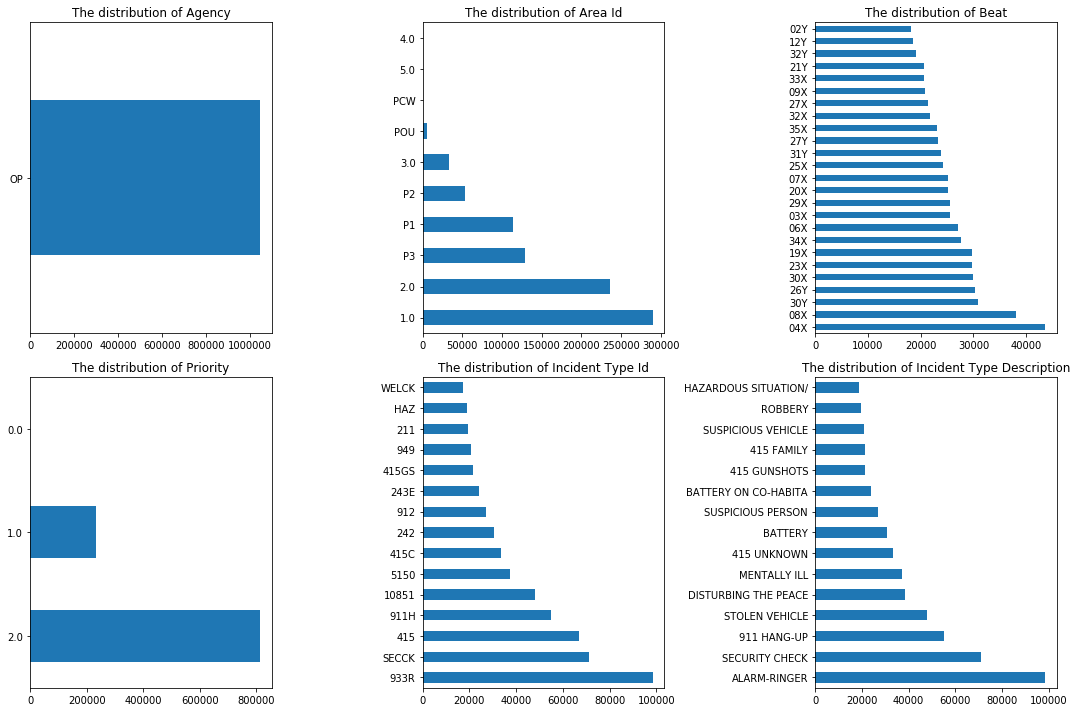

In [15]:
Agency=crime_data['Agency'].value_counts()
Area_Id=crime_data['Area_Id'].value_counts()
Beat=crime_data['Beat'].value_counts()
Priority=crime_data['Priority'].value_counts()
Incident_Type_Id=crime_data['Incident_Type_Id'].value_counts()
Incident_Type_Description=crime_data['Incident_Type_Description'].value_counts()
Zip_Codes=crime_data['Zip_Codes'].value_counts()
print("The distribution of Agency\n",Agency)
print("The distribution of Area Id\n",Area_Id)
print("The distribution of Beat\n",Beat)
print("The distribution of Priority\n",Priority)
print("The distribution of Incident Type Id\n",Incident_Type_Id)
print("The distribution of Incident Type Description\n",Incident_Type_Description)
top=25
list_nominal=[Agency,Area_Id[:10],Beat[:25],Priority,Incident_Type_Id[:15],Incident_Type_Description[:15]]
list_name=['Agency','Area Id','Beat','Priority','Incident Type Id','Incident Type Description']
fig,axes=plt.subplots(2,3)
for d,i in zip(list_nominal,range(6)):
    ax=axes.ravel()[i]
    ax.set_title(f"The distribution of {list_name[i]}")
    d.plot.barh(ax=ax,figsize=(15,10))
    plt.tight_layout()

Agency的值全部为OP。Priority的值以2.0为主，说明优先级次之的案子较多。案件率最高的地区为1.0地区。

二、数值属性，给出5数概括及缺失值的个数。下面分别计算缺失值个数。

                        index  missNum  missRate
10                  Zip_Codes  1046036  0.999664
3                     Area_Id   182365  0.174280
4                        Beat     5805  0.005548
7   Incident_Type_Description      392  0.000375
2                    Location      112  0.000107
9                 Closed_Time       29  0.000028
0                      Agency        4  0.000004
1                 Create_Time        4  0.000004
5                    Priority        4  0.000004
6            Incident_Type_Id        4  0.000004
8                Event_Number        4  0.000004


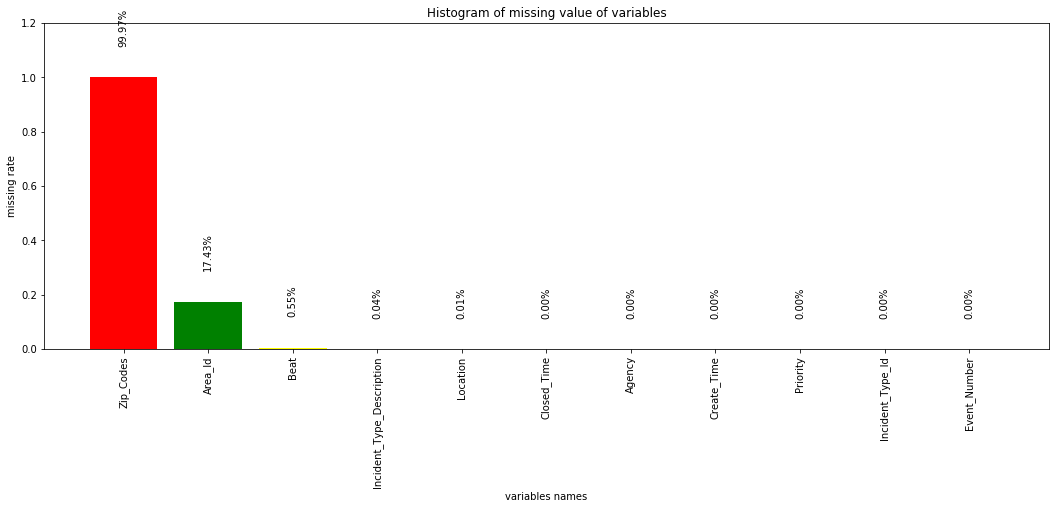

In [16]:
# 统计缺失值数量
missing=crime_data.isnull().sum().reset_index().rename(columns={0:'missNum'})
# 计算缺失比例
missing['missRate']=missing['missNum']/crime_data.shape[0]
# 按照缺失率排序显示
miss_analy=missing[missing.missRate>=0].sort_values(by='missRate',ascending=False)
print(miss_analy)
# miss_analy 存储的是每个变量缺失情况的数据框
fig = plt.figure(figsize=(18,6))
plt.bar(np.arange(miss_analy.shape[0]), list(miss_analy.missRate.values), align = 'center',color=['red','green','yellow','steelblue'])

plt.title('Histogram of missing value of variables')
plt.xlabel('variables names')
plt.ylabel('missing rate')
# 添加x轴标签，并旋转90度
plt.xticks(np.arange(miss_analy.shape[0]),list(miss_analy['index']))
plt.xticks(rotation=90)
# 添加数值显示
for x,y in enumerate(list(miss_analy.missRate.values)):
    plt.text(x,y+0.12,'{:.2%}'.format(y),ha='center',rotation=90)    
plt.ylim([0,1.2])
    
plt.show()

由上图可看出，此数据集的缺失数据主要集中在zip_codes和Area_id上，zip_codes数据的缺失主要是因为数据是按年份记录的，只有2012年的数据有zip_codes这一列，因此数据缺失率很高。Area_id是代表案件发生区域，有可能出现跨国或者多地区犯案，不好标记地区的情况。

三、数据可视化，使用直方图、盒图等检查数据分布及离群点。只有Create_Time和Closed_Time这两个数值属性，但是不知道怎么回事，我画不出来图了。就把频率最高的前25画出来。

The distribution of Create_Time
 2013-01-29T09:16:31.000    18
2014-10-14T02:45:12.000    14
2014-10-14T02:46:45.000    11
2012-06-26T00:00:00.000     8
2012-05-07T00:00:00.000     7
                           ..
2012-02-15T07:31:33.000     1
2012-06-30T19:07:07.000     1
2016-05-20T15:34:59.000     1
2012-03-19T04:06:30.000     1
2012-12-26T19:56:04.000     1
Name: Create_Time, Length: 1042933, dtype: int64
The distribution of Closed_Time Id
 2013-09-01T17:23:50.000    4
2013-02-12T22:52:01.000    4
2013-04-26T21:30:39.000    3
2014-06-20T01:44:34.000    3
2014-06-04T16:31:09.000    3
                          ..
2013-06-15T18:00:45.000    1
2012-10-10T12:22:16.000    1
2013-08-19T14:34:55.000    1
2012-05-20T11:35:56.000    1
2015-10-29T23:42:05.000    1
Name: Closed_Time, Length: 1043236, dtype: int64


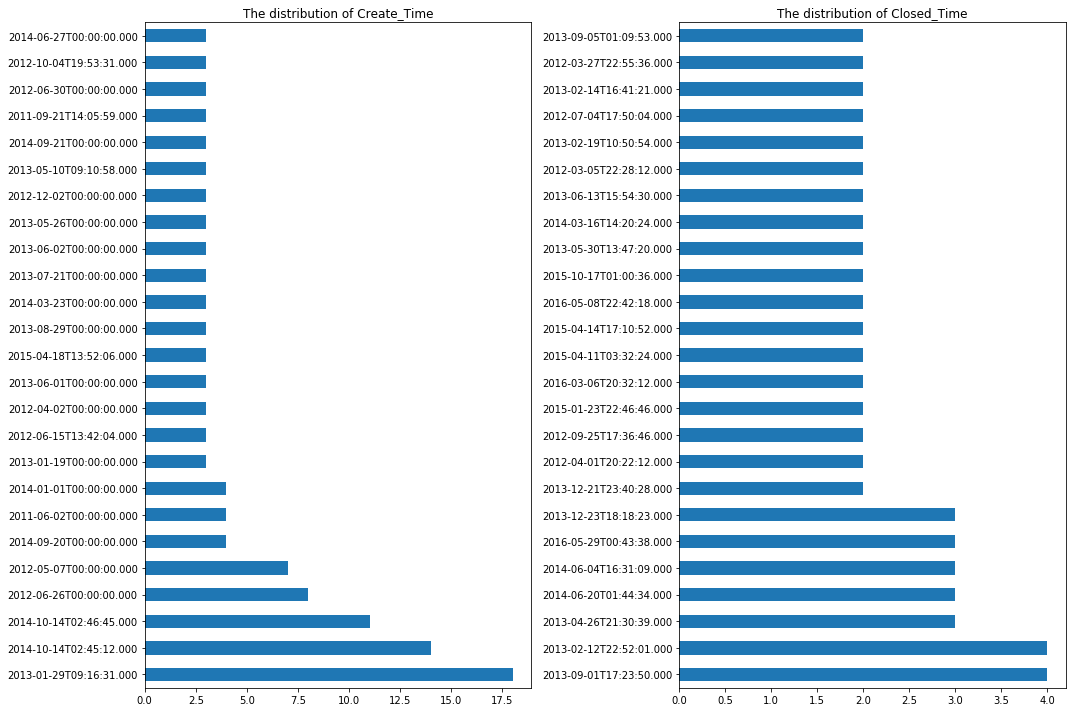

In [17]:
Create_Time=crime_data['Create_Time'].value_counts()
Closed_Time=crime_data['Closed_Time'].value_counts()
print("The distribution of Create_Time\n",Create_Time)
print("The distribution of Closed_Time Id\n",Closed_Time)
top=25
list_nominal=[Create_Time[:top],Closed_Time[:top]]
list_name=['Create_Time','Closed_Time']
fig,axes=plt.subplots(1,2)
for d,i in zip(list_nominal,range(6)):
    ax=axes.ravel()[i]
    ax.set_title(f"The distribution of {list_name[i]}")
    d.plot.barh(ax=ax,figsize=(15,10))
    plt.tight_layout()

Create_Time和Closed_Time都各自有4个缺失值，但因为数据量庞大，可视化也难以观察出区别,补全方法同上一数据集。